In [ ]:
# Run in anaconda terminal: conda install -c conda-forge imbalanced-learn
# pip install keras
# pip install tensorflow
# http://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import requests
import numpy as np
# Import necessary libraries
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, precision_score, f1_score, auc
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt


np.seterr(over='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Multiclass SVM using mini-batch Stochastic Gradient Descent (mbSGD) solver.

First we will develop the mini-batch Stochastic Gradient Descent (mbSGD) optimization algorithm to find the optimal parameters  of Multiclass SVM algorithm.

The mathematical objective function for the soft margin SVM using parameters w and b is given by:

$min(1/2 * ||w||^2 + C * \sum_{i=1}^{n}[y(i) * max(0, 1- w * x(i) + b)])$

where C is the penalty term,  
x(i) is the ith training data point,   
y(i) is the corresponding label (1 or -1), 
and ||w|| is the norm of the weight vector w.   

The function seeks to minimize the sum of the distance of the points from the decision boundary (measured by the norm of w) and the penalty for misclassifications (measured by the max function).

Below we create the class SVM which utilizes mini-batch Stochastic Gradient Descent (mbSGD):

In [6]:
class MySVM:

    def __init__(self, C=1.0):
        self.C = C
        self.X = None
        self.y = None
        self.w = None
        self.b = None
        self.batch_size= None
        self.learning_rate = None
        self.num_iterations= None

    def gradients(self, X, y):
        n, m = X.shape
        gradients = np.zeros((m, 1)) 
        for i in range(n):
            x_i = X[i].reshape(-1, 1)
            y_i = y[i].reshape(-1, 1)
            if 1 - y_i * (np.dot(self.w.T, x_i) + self.b) >= 0:
                gradients += -self.C * y_i * x_i
        return gradients


    def objective(self, X, y):
            n, m = X.shape
            result = 0
            for i in range(n):
                x_i = X[i].reshape(-1, 1)
                y_i = y[i].reshape(-1, 1)
                result += max(0, 1 - y_i * (np.dot(self.w.T, x_i) + self.b))
            result *= self.C
            result += 0.5 * np.dot(self.w.T, self.w)
            return result

    def fit(self, X, y, batch_size= 100, learning_rate = 0.001, num_iterations=400):
        """
        Minimize the objective function using mini-batch gradient descent
        and store the parameters w, b  which produce the minimum value
        along with corresconding value of the objective function for each iteration.
        """
        self.X = X
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_iterations= num_iterations
        n, m = X.shape
        self.y = y
        self.w = np.zeros((m, 1))
        self.b = 0
        objective_history = []
        for i in range(num_iterations):
            random_observations = np.random.permutation(n)
            X_mixed = X[random_observations]
            y_mixed = y[random_observations]
            for j in range(0, n, batch_size):
                X_batch = X_mixed[j:j + batch_size]
                y_batch = y_mixed[j:j + batch_size]
                gradients = self.gradients(X_batch, y_batch)
                self.w = self.w - learning_rate * gradients
                self.b = self.b - learning_rate * np.mean(self.C * y_batch * (1 - y_batch * (np.dot(X_batch, self.w) + self.b)))
                objective_value = self.objective(X_batch, y_batch)
                objective_history.append(objective_value)
        return self.w, self.b, objective_history
    
    def predict_proba(self, X):
        scores = np.dot(X, self.w)
        scores += self.b
        return 1 / (1 + np.exp(-scores)).reshape(-1)

    
    def predict(self, X):
        scores = np.dot(X, self.w)
        scores += self.b
        if len(np.unique(self.y)) == 2:
            return np.where(scores > 0, 1, -1)
        else:
            class_probs = []
            for c in np.unique(self.y):
                y_binary = np.where(self.y == c, 1, -1)
                svm = MySVM(C=self.C)
                svm.fit(self.X,
                        y_binary, 
                        batch_size = self.batch_size, 
                        learning_rate = self.learning_rate, 
                        num_iterations = self.num_iterations)
                probs = svm.predict_proba(X)
                class_probs.append(probs)
            class_probs = np.asarray(class_probs).T
            class_probs = class_probs.astype(float)
            return np.argmax(class_probs, axis=1)




# Following we will load the datasets breast-cancer and diabetes from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/.



## Iris dataset

In [7]:
iris = datasets.load_iris() #Loading the dataset
iris = pd.DataFrame(
    data= np.c_[iris['data'], iris['target']],
    columns= iris['feature_names'] + ['target']
    )
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


## Breast cancer dataset

In [8]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
names = ['id', 'clump_thickness', 'uniform_cell_size', 'uniform_cell_shape', 
         'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei',
         'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']

breast_cancer = pd.read_csv(url, names=names).replace('?', np.nan).dropna()
breast_cancer["class"]=np.where(breast_cancer["class"]==4,1,-1)
# breast_cancer[breast_cancer["class"]==0] = -1
breast_cancer.head(20)

,id,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,-1
1,1002945,5,4,4,5,7,10,3,2,1,-1
2,1015425,3,1,1,1,2,2,3,1,1,-1
3,1016277,6,8,8,1,3,4,3,7,1,-1
4,1017023,4,1,1,3,2,1,3,1,1,-1
5,1017122,8,10,10,8,7,10,9,7,1,1
6,1018099,1,1,1,1,2,10,3,1,1,-1
7,1018561,2,1,2,1,2,1,3,1,1,-1
8,1033078,2,1,1,1,2,1,1,1,5,-1
9,1033078,4,2,1,1,2,1,2,1,1,-1


## Diabetes dataset

In [9]:
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes"
response = requests.get(url)

with open("diabetes.txt", "w") as f:
    f.write(response.text)

def split_data(data):
    return data.split(":")[1]

diabetes = pd.read_csv("diabetes.txt", delim_whitespace=True, header=None, nrows=None)
label = diabetes.select_dtypes(include="number")
diabetes_objects = diabetes.select_dtypes(include="object").apply(lambda x: x.apply(split_data))
diabetes = pd.concat([diabetes_objects, label], axis = 1)         
diabetes.columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
diabetes = diabetes.apply(pd.to_numeric, errors='coerce') #Convert argument to numeric type and invalid parsing is set as NaN
diabetes = diabetes.dropna() #Rewrrite previous data entry with new complete data    

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.599998,0.627,50.0,-1
1,1.0,85.0,66.0,29.0,0.0,26.600000,0.351,31.0,1
2,8.0,183.0,64.0,0.0,0.0,23.299999,0.672,32.0,-1
3,1.0,89.0,66.0,23.0,94.0,28.100000,0.167,21.0,1
4,0.0,137.0,40.0,35.0,168.0,43.099998,2.288,33.0,-1


The optimal number of iterations and number of batches for mini-batch gradient descent on an SVM algorithm will depend on several factors, including the size and complexity of the dataset, the learning rate, and the desired level of accuracy.

In general, increasing the number of iterations and the number of batches will result in a more accurate model, but it will also increase the computational cost and the training time. Therefore, finding the optimal number of iterations and batches will require a trade-off between accuracy and computational cost.

One approach to finding the optimal number of iterations and batches is to start with a small number of iterations and batches, and then gradually increase them while monitoring the performance of the model. Another approach would be to use grid search or random search to systematically explore different combinations of the number of iterations and batches and find the combination that produces the best performance on a validation dataset. This approach can be more computationally expensive, but it can provide more accurate results.


## Evaluation for breast cancer dataset:

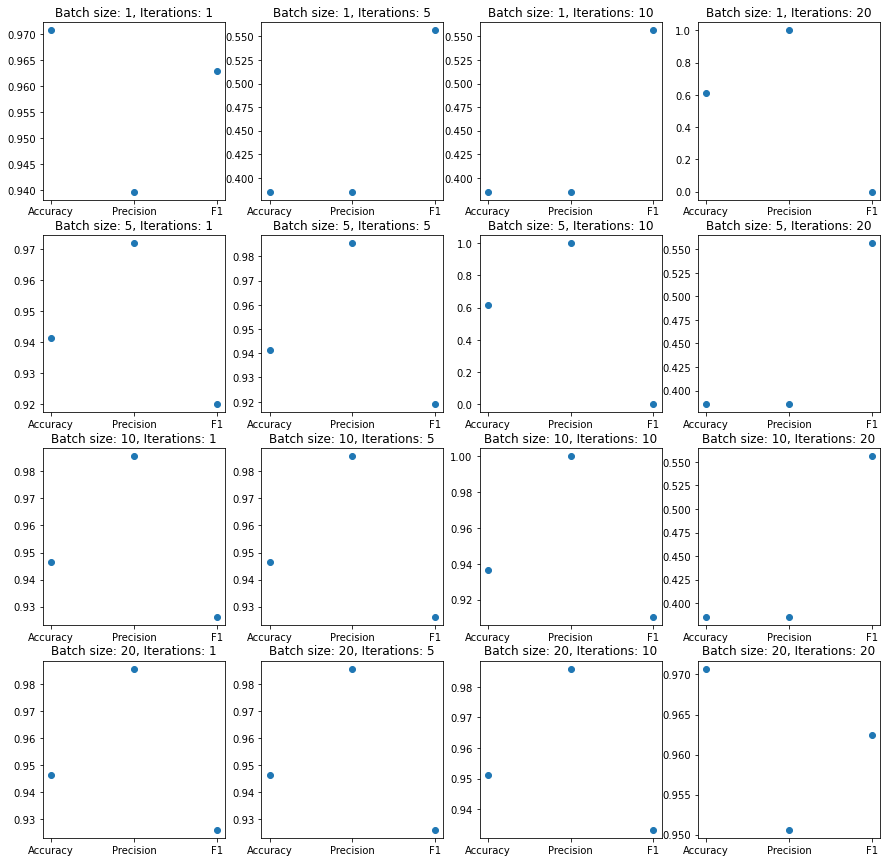

    Batch size  Iterations  Accuracy  Precision        F1
0            1           1  0.970732   0.939759  0.962963
1            1           5  0.385366   0.385366  0.556338
2            1          10  0.385366   0.385366  0.556338
3            1          20  0.614634   1.000000  0.000000
4            5           1  0.941463   0.971831  0.920000
5            5           5  0.941463   0.985507  0.918919
6            5          10  0.614634   1.000000  0.000000
7            5          20  0.385366   0.385366  0.556338
8           10           1  0.946341   0.985714  0.926174
9           10           5  0.946341   0.985714  0.926174
10          10          10  0.936585   1.000000  0.910345
11          10          20  0.385366   0.385366  0.556338
12          20           1  0.946341   0.985714  0.926174
13          20           5  0.946341   0.985714  0.926174
14          20          10  0.951220   0.985915  0.933333
15          20          20  0.970732   0.950617  0.962500


In [12]:
X = breast_cancer.drop(['class'], axis=1).to_numpy()
y = breast_cancer['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

clf = MySVM(C = 10)

num_batches = [1, 5, 10, 20]
num_iterations = [1, 5, 10, 20]


fig, axs = plt.subplots(len(num_batches), len(num_iterations), figsize=(15, 15))
results = []
for i, b in enumerate(num_batches):
    for j, it in enumerate(num_iterations):
        clf.fit(X_train_scaled, y_train_resampled, batch_size=b, num_iterations=it)
        predictions  = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions,  zero_division=1)
        f1 = f1_score(y_test, predictions, zero_division=1)
        results.append((b, it, accuracy, precision, f1))
        
        axs[i][j].scatter([0, 1, 2], [accuracy, precision, f1])
        axs[i][j].set_title(f'Batch size: {b}, Iterations: {it}')
        axs[i][j].set_xticks([0, 1, 2])
        axs[i][j].set_xticklabels(['Accuracy', 'Precision', 'F1'])
plt.show()

results_df = pd.DataFrame(results, columns=['Batch size', 'Iterations', 'Accuracy', 'Precision', 'F1'])
print(results_df)

## Evaluation for Diabetes dataset:

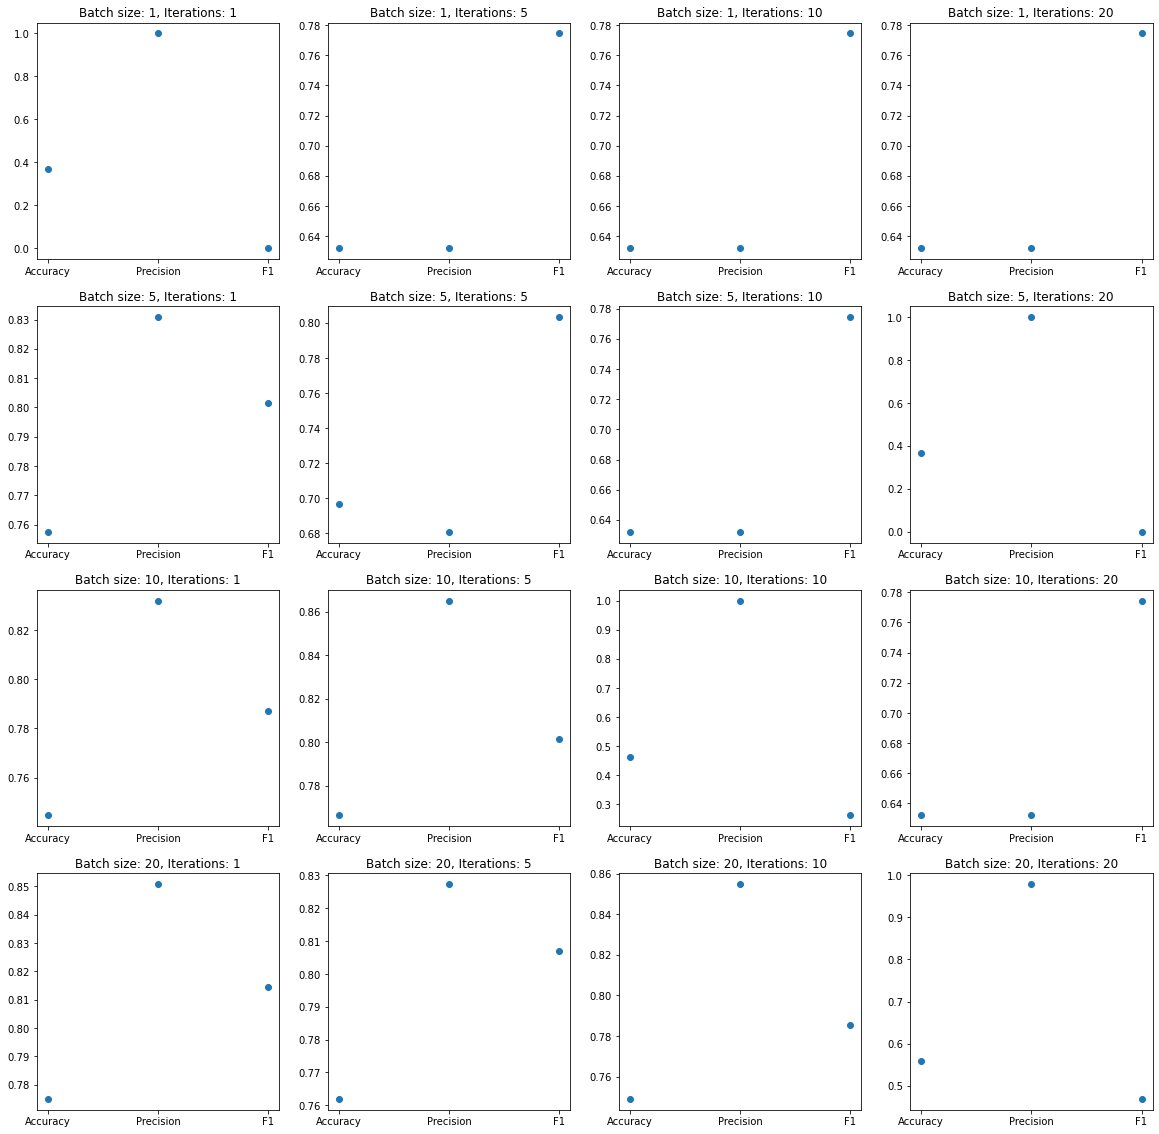

    Batch size  Iterations  Accuracy  Precision        F1
0            1           1  0.367965   1.000000  0.000000
1            1           5  0.632035   0.632035  0.774536
2            1          10  0.632035   0.632035  0.774536
3            1          20  0.632035   0.632035  0.774536
4            5           1  0.757576   0.830882  0.801418
5            5           5  0.696970   0.680952  0.803371
6            5          10  0.632035   0.632035  0.774536
7            5          20  0.367965   1.000000  0.000000
8           10           1  0.744589   0.832061  0.787004
9           10           5  0.766234   0.865079  0.801471
10          10          10  0.463203   1.000000  0.261905
11          10          20  0.632035   0.632035  0.774536
12          20           1  0.774892   0.850746  0.814286
13          20           5  0.761905   0.827338  0.807018
14          20          10  0.748918   0.854839  0.785185
15          20          20  0.558442   0.978261  0.468750


In [13]:
X = diabetes.drop(['Outcome'], axis=1).to_numpy()
y = diabetes['Outcome'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

clf = MySVM(C = 10)

num_batches = [1, 5, 10, 20]
num_iterations = [1, 5, 10, 20]


fig, axs = plt.subplots(len(num_batches), len(num_iterations), figsize=(20, 20))
results = []
for i, b in enumerate(num_batches):
    for j, it in enumerate(num_iterations):
        clf.fit(X_train_scaled, y_train_resampled, batch_size=b, num_iterations=it)
        predictions  = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions,  zero_division=1)
        f1 = f1_score(y_test, predictions, zero_division=1)
        results.append((b, it, accuracy, precision, f1))
        
        axs[i][j].scatter([0, 1, 2], [accuracy, precision, f1])
        axs[i][j].set_title(f'Batch size: {b}, Iterations: {it}')
        axs[i][j].set_xticks([0, 1, 2])
        axs[i][j].set_xticklabels(['Accuracy', 'Precision', 'F1'])
plt.show()

results_df = pd.DataFrame(results, columns=['Batch size', 'Iterations', 'Accuracy', 'Precision', 'F1'])

print(results_df)

## Evaluation of Iris dataset

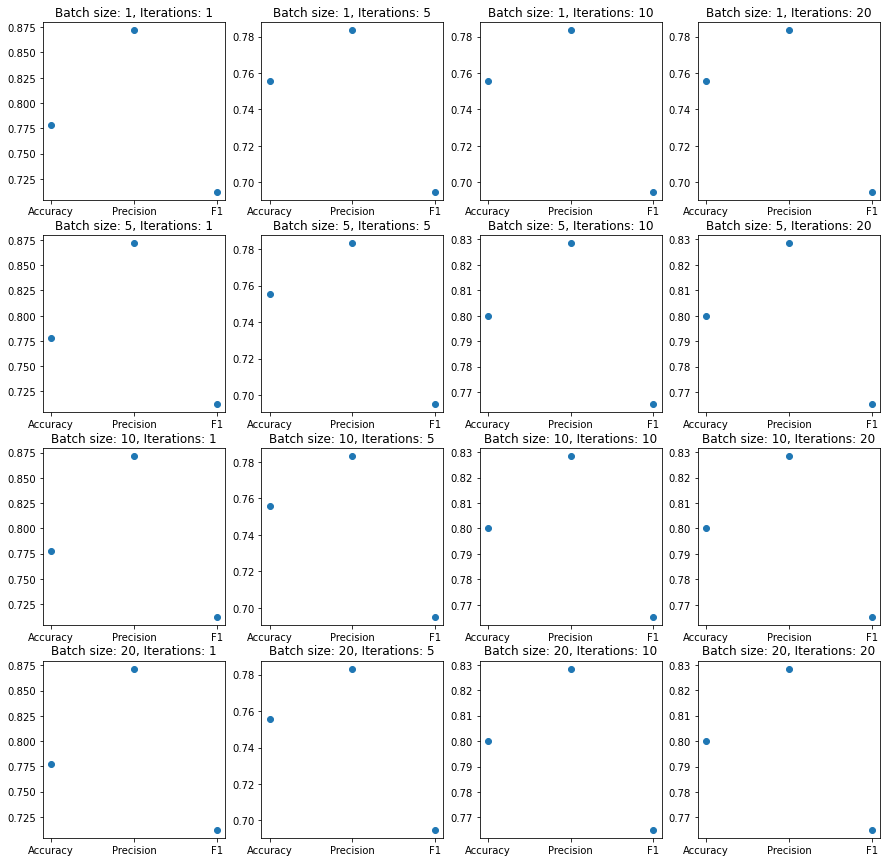

    Batch size  Iterations  Accuracy  Precision        F1
0            1           1  0.777778   0.871795  0.712302
1            1           5  0.755556   0.783333  0.694883
2            1          10  0.755556   0.783333  0.694883
3            1          20  0.755556   0.783333  0.694883
4            5           1  0.777778   0.871795  0.712302
5            5           5  0.755556   0.783333  0.694883
6            5          10  0.800000   0.828502  0.765182
7            5          20  0.800000   0.828502  0.765182
8           10           1  0.777778   0.871795  0.712302
9           10           5  0.755556   0.783333  0.694883
10          10          10  0.800000   0.828502  0.765182
11          10          20  0.800000   0.828502  0.765182
12          20           1  0.777778   0.871795  0.712302
13          20           5  0.755556   0.783333  0.694883
14          20          10  0.800000   0.828502  0.765182
15          20          20  0.800000   0.828502  0.765182


In [14]:
X = iris.drop(['target'], axis=1).to_numpy()
y = iris['target'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

clf = MySVM(C = 1)

num_batches = [1, 5, 10, 20]
num_iterations = [1, 5, 10, 20]

fig, axs = plt.subplots(len(num_batches), len(num_iterations), figsize=(15, 15))
results = []

for i, b in enumerate(num_batches):
    for j, it in enumerate(num_iterations):
        clf.fit(X_train_scaled, y_train_resampled, batch_size=b, num_iterations=it)
        predictions  = clf.predict(X_test_scaled)
        precision = precision_score(y_test, predictions, average='macro', zero_division=1)
        f1 = f1_score(y_test, predictions, average='macro', zero_division=1)
        accuracy = accuracy_score(y_test, predictions)    
        results.append((b, it, accuracy, precision, f1))
        axs[i][j].scatter([0, 1, 2], [accuracy, precision, f1])
        axs[i][j].set_title(f'Batch size: {b}, Iterations: {it}')
        axs[i][j].set_xticks([0, 1, 2])
        axs[i][j].set_xticklabels(['Accuracy', 'Precision', 'F1'])
plt.show()

results_df = pd.DataFrame(results, columns=['Batch size', 'Iterations', 'Accuracy', 'Precision', 'F1'])

print(results_df)

# Comparison

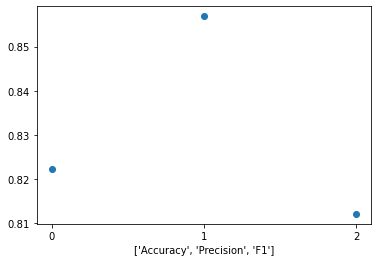

   Accuracy  Precision        F1
0  0.822222   0.856884  0.812121
                                              Actual  \
0  [0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, ...   

                                          Prediction  
0  [0, 1, 2, 1, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, ...  


In [15]:
X = iris.drop(['target'], axis=1).to_numpy()
y = iris['target'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

clf = MySVM(C = 0.1)
clf.fit(X_train_scaled, y_train_resampled, batch_size=1, num_iterations=100)
predictions  = clf.predict(X_test_scaled)

precision = precision_score(y_test, predictions, average='macro', zero_division=1)
f1 = f1_score(y_test, predictions, average='macro', zero_division=1)
accuracy = accuracy_score(y_test, predictions)    

plt.scatter([0, 1, 2], [accuracy, precision, f1])
plt.xticks([0, 1, 2])
plt.xlabel(['Accuracy', 'Precision', 'F1'])
plt.show()     

results = [[accuracy], [precision], [f1]]
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'F1'])
print(results_df.T)


actual_vs_pred = [[y_test], [predictions]]
actual_vs_pred_df = pd.DataFrame(actual_vs_pred, index=['Actual', 'Prediction'])
print(actual_vs_pred_df.T)

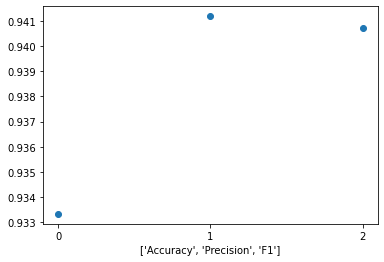

   Accuracy  Precision        F1
0  0.933333   0.941176  0.940715
                                              Actual  \
0  [1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, ...   

                                          Prediction  
0  [1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, ...  


''

In [16]:
from sklearn.neighbors import KNeighborsClassifier
X = iris.drop(['target'], axis=1).to_numpy()
y = iris['target'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

clf = KNeighborsClassifier()

clf.fit(X_train_scaled, y_train_resampled)
predictions  = clf.predict(X_test_scaled)
precision = precision_score(y_test, predictions, average='macro', zero_division=1)
f1 = f1_score(y_test, predictions, average='macro', zero_division=1)
accuracy = accuracy_score(y_test, predictions)    

plt.scatter([0, 1, 2], [accuracy, precision, f1])
plt.xticks([0, 1, 2])
plt.xlabel(['Accuracy', 'Precision', 'F1'])
plt.show()


results = [[accuracy], [precision], [f1]]
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'F1'])
print(results_df.T)


actual_vs_pred = [[y_test], [predictions]]
actual_vs_pred_df = pd.DataFrame(actual_vs_pred, index=['Actual', 'Prediction'])
print(actual_vs_pred_df.T)
, 

# Image classification

The CIFAR-10 dataset is a dataset of 32x32x3 images, which means that each image has three color channels (red, green, and blue) and 32 rows and 32 columns. This means that the input data for the CIFAR-10 dataset has four dimensions: the number of samples, the number of rows, the number of columns, and the number of channels.

In [17]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [18]:
def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

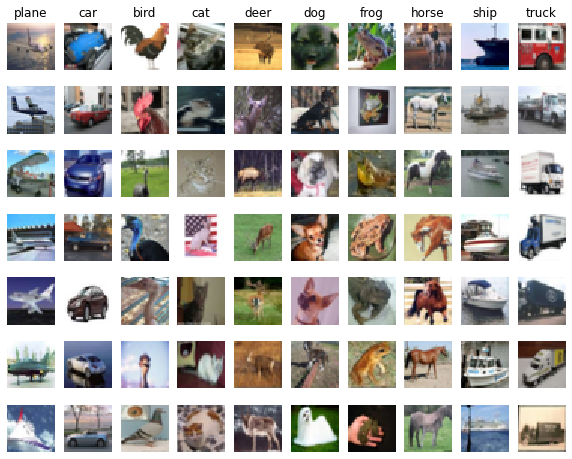

In [61]:
visualize_sample(X_train, y_train, classes)

In [ ]:
from sklearn.svm import SVC

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Reshape the input data to have only two dimensions
X_train = X_train.reshape((-1, 32 * 32 * 3))
X_test = X_test.reshape((-1, 32 * 32 * 3))

# Convert the target labels to a one-dimensional array
y_train = y_train.ravel()
y_test = y_test.ravel()

# Create an SVC model using SGD
svm_sgd = MySVM(C = 0.1)
# svm_sgd = SVC(kernel="linear", C=1.0, max_iter=400, tol=1e-3)

# Train the model on the training data
svm_sgd.fit(X_train, y_train)

# Evaluate the model on the test data
test_accuracy = svm_sgd.score

test_accuracy